# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block14_sepconv2']
    LAST_LAYER = 'block14_sepconv2'
    PREPROCESSING = tf.keras.applications.xception.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7764 - accuracy: 0.7440

947/947 [==============================] - 2523s 3s/step - loss: 0.7764 - accuracy: 0.7440 - val_loss: 0.7137 - val_accuracy: 0.7522
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7748

947/947 [==============================] - 2439s 3s/step - loss: 0.6565 - accuracy: 0.7748 - val_loss: 0.6507 - val_accuracy: 0.7793
Epoch 3/200
947/947 [==============================] - 2421s 3s/step - loss: 0.6076 - accuracy: 0.7897 - val_loss: 0.6943 - val_accuracy: 0.7700
Epoch 4/200
947/947 [==============================] - 2408s 3s/step - loss: 0.5708 - accuracy: 0.8000 - val_loss: 0.6996 - val_accuracy: 0.7637
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.8102

947/947 [==============================] - 2512s 3s/step - loss: 0.5460 - accuracy: 0.8102 - val_loss: 0.6409 - val_accuracy: 0.7784
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.8165

947/947 [==============================] - 2606s 3s/step - loss: 0.5223 - accuracy: 0.8165 - val_loss: 0.5656 - val_accuracy: 0.8036
Epoch 7/200
947/947 [==============================] - 2431s 3s/step - loss: 0.5027 - accuracy: 0.8214 - val_loss: 0.5749 - val_accuracy: 0.7976
Epoch 8/200
947/947 [==============================] - 2432s 3s/step - loss: 0.4867 - accuracy: 0.8279 - val_loss: 0.6193 - val_accuracy: 0.7905
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.4609 - accuracy: 0.8394

947/947 [==============================] - 2576s 3s/step - loss: 0.4609 - accuracy: 0.8394 - val_loss: 0.5214 - val_accuracy: 0.8235
Epoch 10/200
947/947 [==============================] - 2866s 3s/step - loss: 0.4428 - accuracy: 0.8427 - val_loss: 0.5575 - val_accuracy: 0.8082
Epoch 11/200
947/947 [==============================] - 2867s 3s/step - loss: 0.4321 - accuracy: 0.8466 - val_loss: 0.5339 - val_accuracy: 0.8159
Epoch 12/200
947/947 [==============================] - 2890s 3s/step - loss: 0.4157 - accuracy: 0.8513 - val_loss: 0.5612 - val_accuracy: 0.8196
Epoch 13/200
947/947 [==============================] - 2885s 3s/step - loss: 0.3966 - accuracy: 0.8558 - val_loss: 0.5427 - val_accuracy: 0.8153
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8604

947/947 [==============================] - 2894s 3s/step - loss: 0.3884 - accuracy: 0.8604 - val_loss: 0.5055 - val_accuracy: 0.8179
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.3720 - accuracy: 0.8674

947/947 [==============================] - 2891s 3s/step - loss: 0.3720 - accuracy: 0.8674 - val_loss: 0.4819 - val_accuracy: 0.8424
Epoch 16/200
947/947 [==============================] - 2628s 3s/step - loss: 0.3556 - accuracy: 0.8702 - val_loss: 0.5639 - val_accuracy: 0.8225
Epoch 17/200
947/947 [==============================] - 2418s 3s/step - loss: 0.3434 - accuracy: 0.8762 - val_loss: 0.4836 - val_accuracy: 0.8374
Epoch 18/200
947/947 [==============================] - 2415s 3s/step - loss: 0.3305 - accuracy: 0.8782 - val_loss: 0.5376 - val_accuracy: 0.8253
Epoch 19/200
947/947 [==============================] - 2419s 3s/step - loss: 0.3189 - accuracy: 0.8818 - val_loss: 0.5292 - val_accuracy: 0.8284
Epoch 20/200
947/947 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.8894

947/947 [==============================] - 2435s 3s/step - loss: 0.3047 - accuracy: 0.8894 - val_loss: 0.4658 - val_accuracy: 0.8481
Epoch 21/200
947/947 [==============================] - 2409s 3s/step - loss: 0.2959 - accuracy: 0.8903 - val_loss: 0.5634 - val_accuracy: 0.8235
Epoch 22/200
947/947 [==============================] - 2385s 3s/step - loss: 0.2847 - accuracy: 0.8995 - val_loss: 0.4872 - val_accuracy: 0.8426
Epoch 23/200
947/947 [==============================] - 2383s 3s/step - loss: 0.2732 - accuracy: 0.8993 - val_loss: 0.5003 - val_accuracy: 0.8349
Epoch 24/200
947/947 [==============================] - 2413s 3s/step - loss: 0.2561 - accuracy: 0.9068 - val_loss: 0.5029 - val_accuracy: 0.8357
Epoch 25/200
947/947 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.9089

947/947 [==============================] - 2401s 3s/step - loss: 0.2515 - accuracy: 0.9089 - val_loss: 0.4546 - val_accuracy: 0.8515
Epoch 26/200
947/947 [==============================] - 2387s 3s/step - loss: 0.2374 - accuracy: 0.9152 - val_loss: 0.4666 - val_accuracy: 0.8498
Epoch 27/200
947/947 [==============================] - 2394s 3s/step - loss: 0.2285 - accuracy: 0.9165 - val_loss: 0.5184 - val_accuracy: 0.8492
Epoch 28/200
947/947 [==============================] - 2386s 3s/step - loss: 0.2195 - accuracy: 0.9198 - val_loss: 0.6508 - val_accuracy: 0.8247
Epoch 29/200
947/947 [==============================] - 2383s 3s/step - loss: 0.2083 - accuracy: 0.9228 - val_loss: 0.5307 - val_accuracy: 0.8436
Epoch 30/200
947/947 [==============================] - 2391s 3s/step - loss: 0.2027 - accuracy: 0.9254 - val_loss: 0.5731 - val_accuracy: 0.8299
Epoch 31/200
947/947 [==============================] - 2424s 3s/step - loss: 0.1910 - accuracy: 0.9308 - val_loss: 0.5191 - val_accuracy

947/947 [==============================] - 2424s 3s/step - loss: 0.1841 - accuracy: 0.9325 - val_loss: 0.4413 - val_accuracy: 0.8605
Epoch 33/200
947/947 [==============================] - 2411s 3s/step - loss: 0.1778 - accuracy: 0.9356 - val_loss: 0.5785 - val_accuracy: 0.8507
Epoch 34/200
947/947 [==============================] - 2437s 3s/step - loss: 0.1736 - accuracy: 0.9373 - val_loss: 0.5602 - val_accuracy: 0.8498
Epoch 35/200
947/947 [==============================] - 2445s 3s/step - loss: 0.1652 - accuracy: 0.9390 - val_loss: 0.5328 - val_accuracy: 0.8404
Epoch 36/200
947/947 [==============================] - 2414s 3s/step - loss: 0.1555 - accuracy: 0.9432 - val_loss: 0.5146 - val_accuracy: 0.8574
Epoch 37/200
947/947 [==============================] - 2431s 3s/step - loss: 0.1498 - accuracy: 0.9455 - val_loss: 0.5778 - val_accuracy: 0.8492
Epoch 38/200
947/947 [==============================] - 2685s 3s/step - loss: 0.1503 - accuracy: 0.9457 - val_loss: 0.4578 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 252s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9833060383538487,
 'basal cell carcinoma': 0.9895184144642363,
 'dermatofibroma': 0.956504514616794,
 'melanoma': 0.9473885450262592,
 'nevus': 0.9704498845964661,
 'pigmented benign keratosis': 0.9829770338327796,
 'seborrheic keratosis': 0.9568941508586041,
 'solar lentigo': 0.9673247106875426,
 'squamous cell carcinoma': 0.9879955648081101,
 'vascular lesion': 0.9998491931835319}

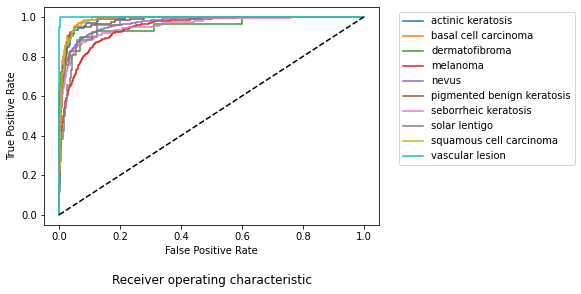

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

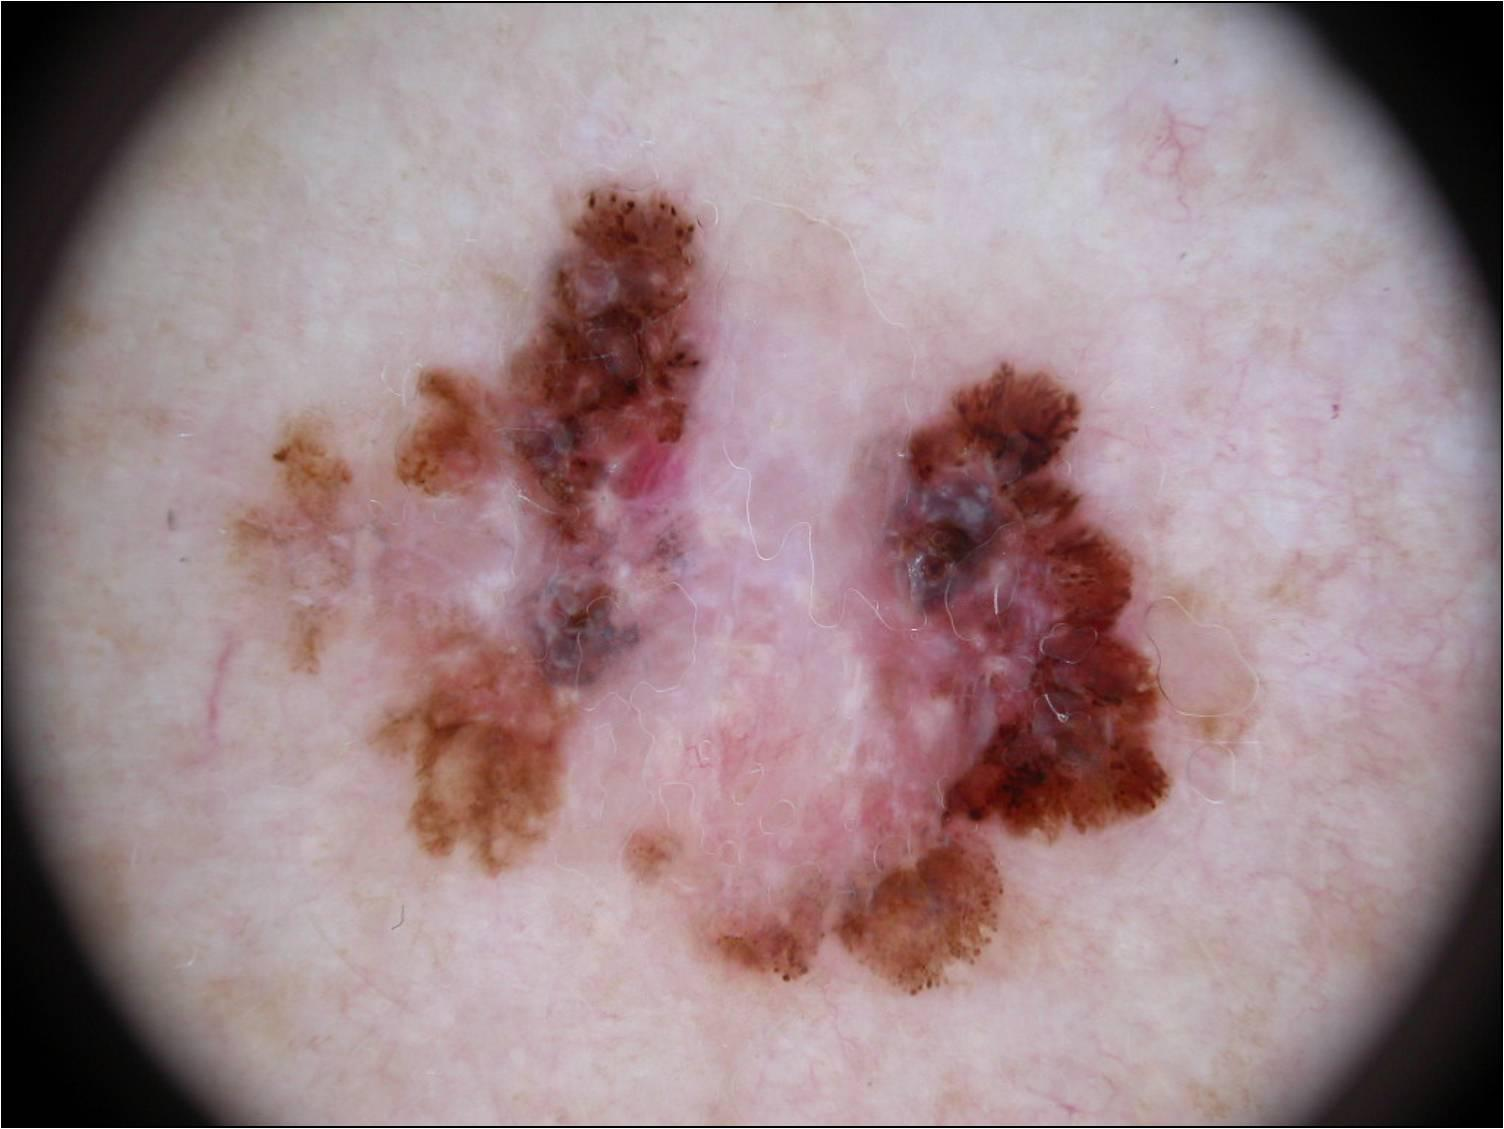

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

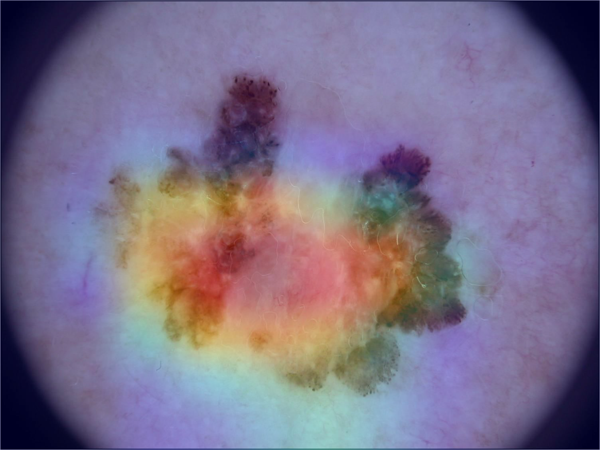

In [23]:
display_gradcam(melanoma_im_path, heatmap)